In [19]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Прочитайте файлы в rdd, проведите их анализ, и расскажите, чем они отличаются (для оценки отлично достаточно чтения файла и просмотра части его содержимого и сравнения названия колонок).**

In [39]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                        0
CPU MHz:                         2199.998
BogoMIPS:                        4399.99
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       32 KiB
L1i cache:                       32 KiB
L2 cache:                        256 KiB
L3 cache:                        55 MiB
NUMA node0 CPU(s):               0,1
Vulnerability 

In [41]:
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt

import requests
from joblib import load

import warnings
warnings.filterwarnings('ignore')

In [42]:
spark = SparkSession.builder\
        .master('local[2]')\
        .appName('Lesson_2')\
        .config('spark.executor.instances', 2)\
        .config('spark.executor.memory', f'{int(12 * 1024 / 2 /1.1)}mb')\
        .config('spark.executor.cores', 1)\
        .getOrCreate()

sc = spark.sparkContext

In [43]:
data_train = sc.textFile('train.csv')
data_test = sc.textFile('test.csv')

display(data_train.take(5), '', data_test.take(5))

['battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range',
 '842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1',
 '1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2',
 '563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2',
 '615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2']

''

['id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi',
 '1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0',
 '2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0',
 '3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1',
 '4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0']

In [44]:
train_header = data_train.first()
test_header = data_test.first()
print(f'{train_header}\n{test_header}')

battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi


train_header имеет целевую переменную price_range, test_header - id



In [45]:
set(train_header.split(',')) ^ set(test_header.split(','))

{'id', 'price_range'}

In [46]:
data_train = data_train.filter(lambda row: row != train_header)
data_test = data_test.filter(lambda row: row != test_header)

In [47]:
def graph(data_train, data_test, col_name, cohort=False, suptitle=False):

    if cohort:
        L_train = lambda row: (str((int(row.split(',')[col_num]) // cohort) * cohort), 1)
        L_test = lambda row: (str((int(row.split(',')[col_num]) // cohort) * cohort), 1)
    else:
        L_train = lambda row: (row.split(',')[col_num], 1)
        L_test = lambda row: (row.split(',')[col_num], 1)
    
    col_num = [x[0] for x in enumerate(train_header.split(',')) if x[1] == col_name][0]

    train_all = data_train \
        .map(L_train) \
        .reduceByKey(lambda x, y: x + y) \
        .sortBy(lambda x: x[1], ascending=False) \
        .collect()

    col_num = [x[0] for x in enumerate(test_header.split(',')) if x[1] == col_name][0]
    test_all = data_test \
        .map(L_test) \
        .reduceByKey(lambda x, y: x + y) \
        .sortBy(lambda x: x[1], ascending=False) \
        .collect()

    train_x, train_y = zip(*train_all)
    test_x, test_y = zip(*test_all)

    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    
    if suptitle:
        fig.suptitle(suptitle, fontsize=16, fontweight='bold')

    ax1, ax2 = ax.flatten()

    ax1.bar(train_x, train_y, color='blue', edgecolor='green')
    ax1.set_title('Train', fontsize=12, fontweight='bold')
    ax1_title_pos = ax1.title.get_position()
    ax1.title.set_position([0, ax1_title_pos[1]])
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax1.grid(axis='y', linewidth=.5)

    ax2.bar(test_x, test_y, color='blue', edgecolor='green')
    ax2.set_title('Test', fontsize=12, fontweight='bold')
    ax2_title_pos = ax2.title.get_position()
    ax2.title.set_position([1, ax2_title_pos[1]])
    ax2.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax2.grid(axis='y', linewidth=.5)

    plt.subplots_adjust(wspace=0.3);

возьмем выборочно несколько показателей для сравнения

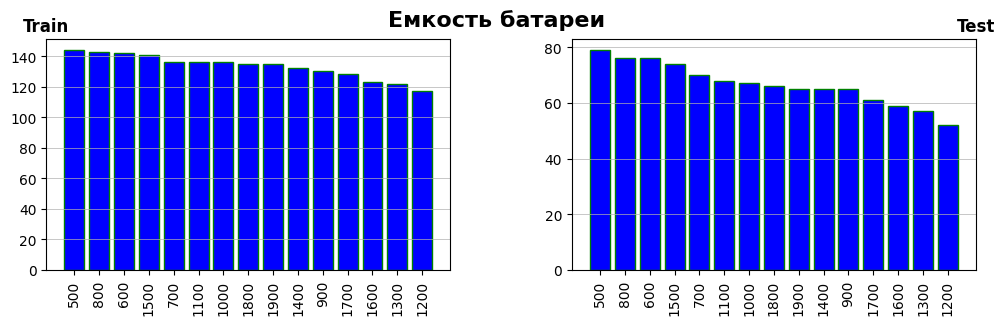

In [50]:
graph(data_train, data_test, 'battery_power', cohort=100, suptitle='Емкость батареи')

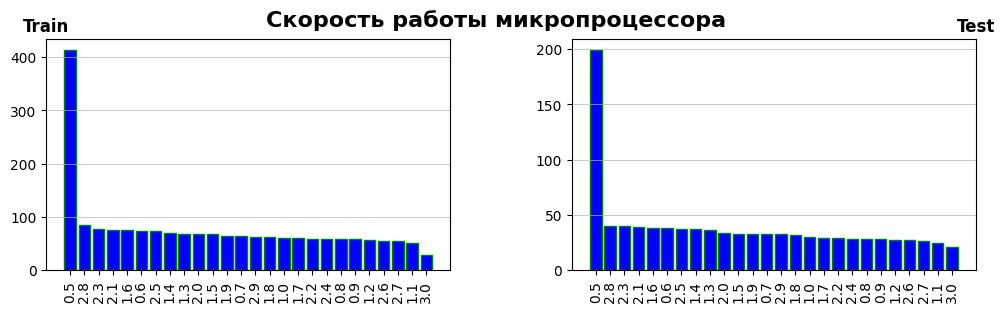

In [51]:
graph(data_train, data_test, 'clock_speed', suptitle='Скорость работы микропроцессора')

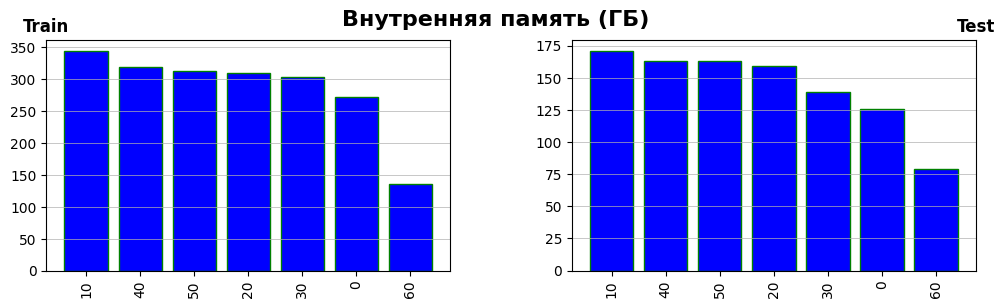

In [52]:
graph(data_train, data_test, 'int_memory', cohort=10, suptitle='Внутренняя память (ГБ)')

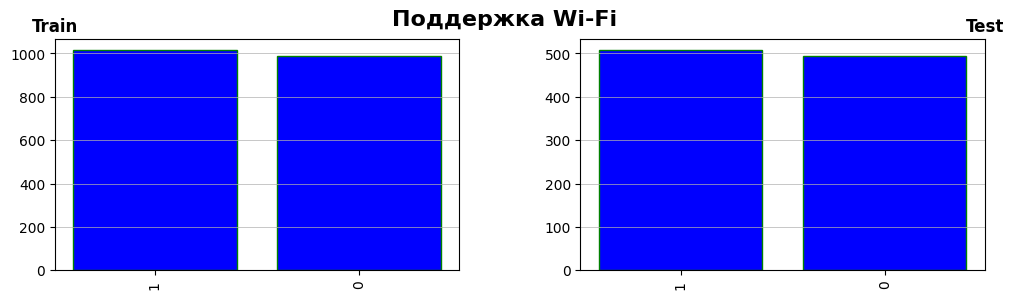

In [53]:
graph(data_train, data_test, 'wifi', suptitle='Поддержка Wi-Fi')

Распределение на графиках показывает, что отличия в файлах train и test заключаются в количестве столбцов, сами значения в файлах распределены практически одинаково.